In [1]:
import pandas as pd
import numpy as np
import math
import dateutil.parser
from pandas.io.json import json_normalize
import json
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 

In [2]:
STATIONS_DATASET = 'Bicimad_Stations2_201906.json'

Descripción de las categorías (en la API de EMT): https://apidocs.emtmadrid.es/#api-Block_4_TRANSPORT_BICIMAD

In [3]:
stations = pd.DataFrame()
with open(STATIONS_DATASET, encoding="utf8", errors='ignore') as f:
    for line in f:
        data = pd.read_json(line)
        stations = pd.concat([stations,data], ignore_index=True)

# Limpieza

In [4]:
stations.tail()

,_id,stations
124036,2019-06-30T23:29:25.645976,"{'activate': 1, 'name': 'Avenida de los Torero..."
124037,2019-06-30T23:29:25.645976,"{'activate': 1, 'name': 'Ventas', 'reservation..."
124038,2019-06-30T23:29:25.645976,"{'activate': 1, 'name': 'Fernando el Catlico',..."
124039,2019-06-30T23:29:25.645976,"{'activate': 1, 'name': 'San Francisco de Sale..."
124040,2019-06-30T23:29:25.645976,"{'activate': 1, 'name': 'Estrecho', 'reservati..."


Normalizamos la columna 'stations' (que viene en formato json).

In [5]:
stations_norm = pd.io.json.json_normalize(stations['stations'])

In [6]:
stations_norm.tail()

,activate,name,reservations_count,light,total_bases,free_bases,number,longitude,no_available,address,latitude,dock_bikes,id
124036,1,Avenida de los Toreros,0,0,27,25,192,-3.6714166,0,"Avda. Toreros,3",40.4318611,2,200
124037,1,Ventas,0,1,27,7,193,-3.6655555,0,"Avda. Toreros, 49",40.4324722,19,201
124038,1,Fernando el Catlico,0,2,27,13,199,-3.7149166,0,"Fernando el Catlico, 61",40.4343611,10,207
124039,1,San Francisco de Sales,0,0,24,17,203,-3.7144722,0,"General Ampudia, 2",40.44175,7,211
124040,1,Estrecho,0,1,27,6,205,-3.7032777,0,"Navarra, 1",40.4535,18,213


In [7]:
stations = stations.drop('stations', axis=1)

In [8]:
stations = stations.join(stations_norm)

In [9]:
stations.head()

,_id,activate,name,reservations_count,light,total_bases,free_bases,number,longitude,no_available,address,latitude,dock_bikes,id
0,2019-06-01T00:27:15.455361,1,Puerta del Sol A,0,1,24,4,1a,-3.7024255,0,Puerta del Sol n 1,40.4168961,15,1
1,2019-06-01T00:27:15.455361,1,Puerta del Sol B,0,1,24,3,1b,-3.7024207,0,Puerta del Sol n 1,40.4170009,17,2
2,2019-06-01T00:27:15.455361,1,Miguel Moya,1,0,24,19,2,-3.7058415,0,Calle Miguel Moya n 1,40.4205886,2,3
3,2019-06-01T00:27:15.455361,1,Plaza Conde Suchil,0,1,18,1,3,-3.7069171,0,Plaza del Conde Suchil n 2-4,40.4302937,15,4
4,2019-06-01T00:27:15.455361,1,Malasaa,0,2,24,11,4,-3.7025875,0,Calle Manuela Malasaa n 5,40.4285524,11,5


A continuación, comprobamos qué features son innecesarias y las descartamos:

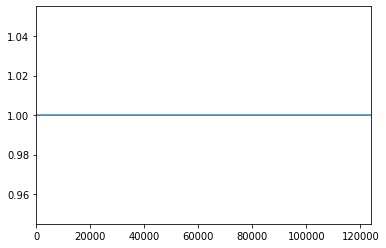

In [10]:
stations['activate'].plot() #Resulta que 'activate' vale 1 en todos los casos

Descartamos:
- el nombre y la dirección, porque podemos identificar cada estación a través de su id (único para cada una)
- activate, el número de reservas y el código de la subparte de la estación ('number'), porque no nos aportan información distintiva.
- la longitud y latitud, dado que no nos vamos a centrar en las rutas.

In [11]:
stations = stations.drop(['activate','name','reservations_count', 'number', 'address', 'longitude', 'latitude'], axis=1)

In [12]:
stations.tail()

,_id,light,total_bases,free_bases,no_available,dock_bikes,id
124036,2019-06-30T23:29:25.645976,0,27,25,0,2,200
124037,2019-06-30T23:29:25.645976,1,27,7,0,19,201
124038,2019-06-30T23:29:25.645976,2,27,13,0,10,207
124039,2019-06-30T23:29:25.645976,0,24,17,0,7,211
124040,2019-06-30T23:29:25.645976,1,27,6,0,18,213


**Normalizamos '_id '**  

- Lo separamos en fecha y hora ('date' y 'hour')
- Ponemos el mismo formato de fecha que en el dataset de uso (mes-dia-año)

In [13]:
import datetime
stations['_id'] = pd.to_datetime(stations['_id']).dt.strftime("%m-%d-%YT%H:%M:%S")

In [14]:
stations.tail()

,_id,light,total_bases,free_bases,no_available,dock_bikes,id
124036,06-30-2019T23:29:25,0,27,25,0,2,200
124037,06-30-2019T23:29:25,1,27,7,0,19,201
124038,06-30-2019T23:29:25,2,27,13,0,10,207
124039,06-30-2019T23:29:25,0,24,17,0,7,211
124040,06-30-2019T23:29:25,1,27,6,0,18,213


In [15]:
new = stations['_id'].str.split("T", n = 1, expand = True) 

In [16]:
stations['date'] = new[0]
stations['hour'] = new[1]

In [17]:
stations = stations.drop(['_id'], axis=1)
stations.head()

,light,total_bases,free_bases,no_available,dock_bikes,id,date,hour
0,1,24,4,0,15,1,06-01-2019,00:27:15
1,1,24,3,0,17,2,06-01-2019,00:27:15
2,0,24,19,0,2,3,06-01-2019,00:27:15
3,1,18,1,0,15,4,06-01-2019,00:27:15
4,2,24,11,0,11,5,06-01-2019,00:27:15


In [18]:
stations.head()

,light,total_bases,free_bases,no_available,dock_bikes,id,date,hour
0,1,24,4,0,15,1,06-01-2019,00:27:15
1,1,24,3,0,17,2,06-01-2019,00:27:15
2,0,24,19,0,2,3,06-01-2019,00:27:15
3,1,18,1,0,15,4,06-01-2019,00:27:15
4,2,24,11,0,11,5,06-01-2019,00:27:15


# Análisis

**De lo siguiente sacamos:**

- Hay datos para las 24h de cada día de junio, sobre la ocupación de cada estación (a continuación muestro los datos de la estación de id=1 para el día 1-06-2019, se muestra su ocupación en cada hora.
- Cuando no_available=1 : dock_bikes=0, free_bases=0, light=3 (se 'desactiva' la fila = NO TENEMOS DATOS PARA ESTAS HORAS)
- 'light' responde al número de bicis aparcadas (bikes in dockers) - nivel de ocupación (a más bicis aparcadas en la estación, más ocupada está esta)

**Dudas**

- Estoy suponiendo que 'dock_bikes' equivale a las bases ocupadas (bicis aparcadas) y 'free_bases' a las bases libres de ocupación. Pero en la suma no me sale el número total de bases('total_bases'). 
- Siguen sin dar las mates aunque incluya las 'bases reservadas'.

In [19]:
stations[(stations['id'] == 1) & ((stations['date'] == '06-01-2019'))]

,light,total_bases,free_bases,no_available,dock_bikes,id,date,hour
0,1,24,4,0,15,1,06-01-2019,00:27:15
174,2,24,11,0,8,1,06-01-2019,01:27:16
348,0,24,15,0,4,1,06-01-2019,02:27:16
522,0,24,18,0,1,1,06-01-2019,03:27:18
696,0,24,17,0,1,1,06-01-2019,04:27:20
870,0,24,17,0,0,1,06-01-2019,05:27:21
1044,0,24,17,0,1,1,06-01-2019,06:27:21
1218,0,24,18,0,0,1,06-01-2019,07:27:22
1392,3,24,0,1,0,1,06-01-2019,08:27:23
1566,3,24,0,1,0,1,06-01-2019,09:27:26


In [21]:
stations[stations['id'] == 2]['date'].value_counts()

06-02-2019    24
06-12-2019    24
06-01-2019    24
06-07-2019    24
06-08-2019    24
06-21-2019    24
06-15-2019    24
06-11-2019    24
06-10-2019    24
06-29-2019    24
06-03-2019    24
06-18-2019    24
06-09-2019    24
06-24-2019    24
06-30-2019    24
06-17-2019    24
06-20-2019    24
06-06-2019    24
06-16-2019    24
06-28-2019    24
06-27-2019    24
06-25-2019    24
06-04-2019    23
06-26-2019    23
06-22-2019    23
06-23-2019    23
06-19-2019    22
06-05-2019    20
06-13-2019    19
06-14-2019    12
Name: date, dtype: int64

In [23]:
stations[(stations['id'] == 1) & ((stations['date'] == '06-13-2019'))] 

,light,total_bases,free_bases,no_available,dock_bikes,id,date,hour
49599,2,24,14,0,9,1,06-13-2019,00:17:22
49777,0,24,16,0,7,1,06-13-2019,01:17:25
49955,0,24,20,0,3,1,06-13-2019,02:17:27
50133,2,24,8,0,16,1,06-13-2019,03:17:27
50311,2,24,9,0,15,1,06-13-2019,04:17:29
50489,2,24,13,0,11,1,06-13-2019,05:17:32
50667,2,24,13,0,11,1,06-13-2019,06:17:32
50845,2,24,10,0,14,1,06-13-2019,07:17:33
51023,1,24,5,0,18,1,06-13-2019,08:17:34
51201,1,24,3,0,21,1,06-13-2019,09:17:35
